In [1]:
import ARESlatticeStage3v1_9 as ares
import cheetah
import matplotlib.pyplot as plt
import torch

[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.


initializing ocelot...
import: module PYFFTW is not installed. Install it to speed up calculation


### Loading the lattice

The lattice is available in Ocelot's format, so we use the `from_ocelot` class method of `Segement`. Because we only care about the Experimental Area (EA), we then select a subcell of the lattice file of the entire ARES accelerator.

Unlike Cheetah, Ocelot does not support screens. Therefore, when Oceloet `Marker`s have the substiring `"screen"` in their name, Cheetah creates a `Screen` element with default properties and emits a warning about this. We can than manually set the correct screen properties.


In [2]:
segment = cheetah.Segment.from_ocelot(ares.cell, warnings=False).subcell(
    "AREASOLA1", "AREABSCR1"
)

# Manually set screen properties
segment.AREABSCR1.resolution = torch.tensor((2448, 2040), dtype=torch.float32)
segment.AREABSCR1.pixel_size = torch.tensor((3.3198e-6, 2.4469e-6), dtype=torch.float32)

# Set some values on the magnets
segment.AREAMQZM1.k1 = torch.tensor(10.0, dtype=torch.float32)
segment.AREAMQZM2.k1 = torch.tensor(-9.0, dtype=torch.float32)
segment.AREAMCVM1.angle = torch.tensor(1e-3, dtype=torch.float32)
segment.AREAMQZM3.k1 = torch.tensor(-8.0, dtype=torch.float32)
segment.AREAMCHM1.angle = torch.tensor(-2e-3, dtype=torch.float32)

segment

Segment(elements=ModuleList(
  (0): Marker(name='AREASOLA1')
  (1): Drift(length=tensor(0.1750), tracking_method='cheetah', name='Drift_AREASOLA1')
  (2): Quadrupole(length=tensor(0.1220), k1=tensor(10.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM1')
  (3): Drift(length=tensor(0.4280), tracking_method='cheetah', name='Drift_AREAMQZM1')
  (4): Quadrupole(length=tensor(0.1220), k1=tensor(-9.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM2')
  (5): Drift(length=tensor(0.2040), tracking_method='cheetah', name='Drift_AREAMQZM2')
  (6): VerticalCorrector(length=tensor(0.0200), angle=tensor(0.0010), name='AREAMCVM1')
  (7): Drift(length=tensor(0.2040), tracking_method='cheetah', name='Drift_AREAMCVM1')
  (8): Quadrupole(length=tensor(0.1220), k1=tensor(-8.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM3')
  (9): Drift(l

### Load particle distribution

We load the beam both as a `ParameterBeam` and a `ParticleBeam` in order to test Cheetah's speed in both its fastest as well as its full particle tracking mode.


In [3]:
parameter_beam = cheetah.ParameterBeam.from_astra(
    "ACHIP_EA1_2021.1351.001", device="cpu"
)
parameter_beam

ParameterBeam(mu_x=tensor(8.2413e-07), mu_px=tensor(5.9885e-08), mu_y=tensor(-1.7276e-06), mu_py=tensor(-1.1746e-07), sigma_x=tensor(0.0002), sigma_px=tensor(3.6794e-06), sigma_y=tensor(0.0002), sigma_py=tensor(3.6941e-06), sigma_tau=tensor(8.0116e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08)), total_charge=tensor(5.0000e-13))

In [4]:
particle_beam = cheetah.ParticleBeam.from_astra("ACHIP_EA1_2021.1351.001", device="cpu")
particle_beam

ParticleBeam(n=100000, mu_x=tensor(8.2413e-07), mu_px=tensor(5.9885e-08), mu_y=tensor(-1.7276e-06), mu_py=tensor(-1.1746e-07), sigma_x=tensor(0.0002), sigma_px=tensor(3.6794e-06), sigma_y=tensor(0.0002), sigma_py=tensor(3.6941e-06), sigma_tau=tensor(8.0116e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08)) total_charge=tensor(5.0000e-13))

In [5]:
particle_beam_10m = cheetah.ParticleBeam.from_parameters(
    num_particles=10_000_000,
    mu_x=particle_beam.mu_x,
    mu_y=particle_beam.mu_y,
    mu_px=particle_beam.mu_px,
    mu_py=particle_beam.mu_py,
    sigma_x=particle_beam.sigma_x,
    sigma_y=particle_beam.sigma_y,
    sigma_px=particle_beam.sigma_px,
    sigma_py=particle_beam.sigma_py,
    sigma_tau=particle_beam.sigma_tau,
    sigma_p=particle_beam.sigma_p,
    # cor_x=particle_beam.cor_x,
    # cor_y=particle_beam.cor_y,
    # cor_tau=particle_beam.cor_tau,
    energy=particle_beam.energy,
    total_charge=particle_beam.total_charge,
    device=particle_beam.particles.device,
    dtype=particle_beam.particles.dtype,
)
particle_beam_10m

ParticleBeam(n=10000000, mu_x=tensor(7.6383e-07), mu_px=tensor(5.9207e-08), mu_y=tensor(-1.6482e-06), mu_py=tensor(-1.1734e-07), sigma_x=tensor(0.0002), sigma_px=tensor(3.6800e-06), sigma_y=tensor(0.0002), sigma_py=tensor(3.6939e-06), sigma_tau=tensor(8.0125e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08)) total_charge=tensor(5.0000e-13))

### Benchmark

We first start with a simple benchmark just tracking particles.


In [6]:
optimized_segment = segment.transfer_maps_merged(incoming_beam=particle_beam)

#### Parameter Beam


In [7]:
segment.AREABSCR1.is_active = False

In [8]:
%%timeit
outgoing = segment.track(parameter_beam)

862 μs ± 26.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
%%timeit
outgoing = optimized_segment.track(parameter_beam)

70.8 μs ± 2.62 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
outgoing = segment.track(parameter_beam)
outgoing

ParameterBeam(mu_x=tensor(-0.0009), mu_px=tensor(-0.0020), mu_y=tensor(0.0008), mu_py=tensor(0.0007), sigma_x=tensor(0.0001), sigma_px=tensor(0.0001), sigma_y=tensor(9.2004e-06), sigma_py=tensor(0.0003), sigma_tau=tensor(7.9948e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08)), total_charge=tensor(5.0000e-13))

We continue with a benchmark tracking particles and then reading the screen.


In [11]:
segment.AREABSCR1.is_active = True

In [12]:
%%timeit
outgoing = segment.track(parameter_beam)
img = segment.AREABSCR1.reading

24.4 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


ParameterBeam(mu_x=tensor(-0.0009), mu_px=tensor(-0.0020), mu_y=tensor(0.0008), mu_py=tensor(0.0007), sigma_x=tensor(0.0001), sigma_px=tensor(0.0001), sigma_y=tensor(9.2004e-06), sigma_py=tensor(0.0003), sigma_tau=tensor(7.9948e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08)), total_charge=tensor(5.0000e-13))


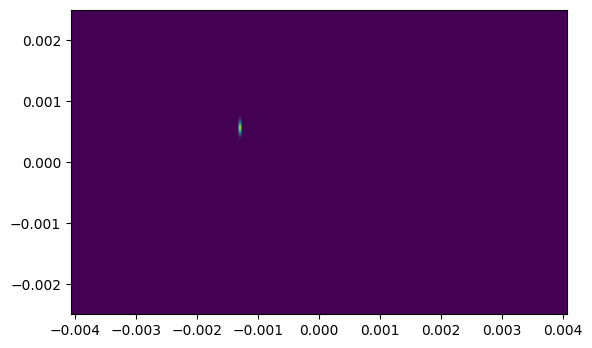

In [13]:
outgoing = segment.track(parameter_beam)
img = segment.AREABSCR1.reading

print(outgoing)  # Should be an empty beam because it is blocked by the screen

plt.imshow(img.numpy(), extent=segment.AREABSCR1.extent.numpy())
plt.show()

#### Particle Beam


In [14]:
segment.AREABSCR1.is_active = False

In [15]:
%%timeit
outgoing = segment.track(particle_beam)

1.98 ms ± 84.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
%%timeit
outgoing = optimized_segment.track(particle_beam)

971 μs ± 30.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
%%timeit
outgoing = segment.track(particle_beam_10m)

46.9 ms ± 379 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit
outgoing = optimized_segment.track(particle_beam_10m)

45.8 ms ± 466 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
outgoing = segment(particle_beam)
outgoing

ParticleBeam(n=100000, mu_x=tensor(-0.0009), mu_px=tensor(-0.0020), mu_y=tensor(0.0008), mu_py=tensor(0.0007), sigma_x=tensor(0.0001), sigma_px=tensor(0.0001), sigma_y=tensor(9.2004e-06), sigma_py=tensor(0.0003), sigma_tau=tensor(7.9948e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08)) total_charge=tensor(5.0000e-13))

We continue with a benchmark tracking particles and then reading the screen.


In [20]:
segment.AREABSCR1.is_active = True

In [21]:
%%timeit
outgoing = segment.track(particle_beam)
img = segment.AREABSCR1.reading

15.4 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%timeit
outgoing = segment.track(particle_beam_10m)
img = segment.AREABSCR1.reading

186 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


ParticleBeam(n=100000, mu_x=tensor(-0.0009), mu_px=tensor(-0.0020), mu_y=tensor(0.0008), mu_py=tensor(0.0007), sigma_x=tensor(0.0001), sigma_px=tensor(0.0001), sigma_y=tensor(9.2004e-06), sigma_py=tensor(0.0003), sigma_tau=tensor(7.9948e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08)) total_charge=tensor(5.0000e-13))


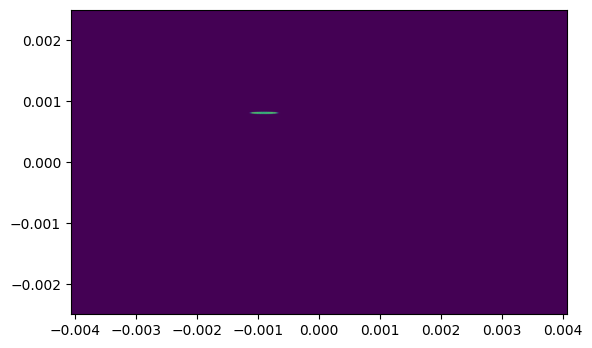

In [23]:
outgoing = segment.track(particle_beam)
img = segment.AREABSCR1.reading

print(outgoing)  # Should be an empty beam because it is blocked by the screen

plt.imshow(img.numpy(), extent=segment.AREABSCR1.extent.numpy())
plt.show()